<h1><center> Tsouros Iakovos Marios </center></h1>
<h1><center> OpenMP Set 2021</center></h1>

## Exercise 1

### Description

Solve the linear wave equation $u_{tt}-\alpha^2u_{xx} = 0$, where $\alpha^2=\frac{2}{\pi^2}$, in ranges $0\leq x\leq12$ using the Lax-Wendroff method:

\begin{equation} u_i^{n+1} = u_i^n - \frac{c}{2}(u_{i+1}^n - u_{i-1}^n) + \frac{c^2}{2}(u_{i+1}{n} - 2u_i^n + u_{i-1}^n) \end{equation}

where $ c = \alpha \frac{\Delta t}{\Delta x}$ and $\Delta t = 0.5 \frac{\Delta x}{\alpha}$.

Initial conditions are: 

* $u(x, 0) = 0$ for $0 \leq x < 2$ and $ 4 < x \leq 12$ else $u(x, 0) = sin(\pi x)$
* $u(0, t) = u(12, t) = 0$

### Assignment


1) Use 200 grid points and plot your solution for $ 0 \leq t \leq 5 \pi$ with a step of $\pi$.

2) Parrallelize the program and compare the execution times for 1,2,4,8 threads. Find the accelaration and plot for the number of threads.

### Solution

The C program that implements the above method can be found under `exercises/exe1/Tsouros_exe1.c` and is presented below.


```c
#include <math.h>
#include <omp.h>
#include <stdio.h>
#include <stdlib.h>

#define M_PI 3.14159265358979323846

int main(int argc, char **argv) {
  double dx, dt, c, temp_M, x_ini = 0.0, x_fin = 12.0, t_ini = 0.0,
                            t_fin = 5 * M_PI, fTimeStart, fTimeEnd;
  double a = sqrt(2 / (pow(M_PI, 2.0)));
  int i, j, N = 200, num_t = 2, M, paral_flag = 0;

  for (i = 1; i < argc; i++) {
    if (argv[i][0] == '-') {
      switch (argv[i][1]) {
      case 'N':
        sscanf(argv[i + 1], "%d", &N);
        break;
      case 't':
        sscanf(argv[i + 1], "%d", &num_t);
        break;
      case 'p':
        paral_flag = 1;
        break;
      }
    }
  }

  // Record start time
  fTimeStart = omp_get_wtime();

  dx = (x_fin - x_ini) / (N - 1);
  dt = 0.5 * (dx / a);
  c = a * (dt / dx);
  temp_M = 1 + (t_fin - t_ini) / dt;
  M = (int)round(temp_M);
  printf("dx = %f, dt = %f, c = %f, M=%d, N=%d a=%f\n", dx, dt, c, M, N, a);
  /* Initialize `u` array */
  double **u = malloc(N * sizeof(double));
  for (i = 0; i < N; i++) {
    u[i] = (double *)malloc(M * sizeof(double));
  }
  /* Initialize time and space arrays */
  double *x, *t;
  x = (double *)malloc(N * sizeof(double));
  t = (double *)malloc(M * sizeof(double));

#pragma omp parallel num_threads(num_t) firstprivate(i, j) if (paral_flag)     \
    shared(x, t, u, dt, dx, N, M, c) default(none)
  {
#pragma omp for
    for (i = 0; i < N; i++) {
      x[i] = 0 + i * dx;
    }

#pragma omp for
    for (i = 0; i < M; i++) {
      t[i] = 0 + i * dt;
    }

/* Initial Conditions */
#pragma omp for
    for (i = 0; i < N; i++) {
      if (x[i] >= 2.0 && x[i] <= 4.0)
        u[i][0] = sin(M_PI * x[i]);
      else
        u[i][0] = 0;
    }
/* boundary conditions. */
#pragma omp for
    for (j = 0; j < M; j++) {
      u[0][j] = 0;
      u[N - 1][j] = 0;
    }
  }
  for (j = 0; j < M - 1; j++) {
#pragma omp parallel num_threads(num_t)                                        \
    firstprivate(N, j) private(i) if (paral_flag) shared(u, c) default(none)
    {
#pragma omp for
      for (i = 1; i < N - 1; i++) {
        u[i][j + 1] =
            u[i][j] - (c / 2.) * (u[i + 1][j] - u[i - 1][j]) +
            (pow(c, 2) / 2.) * (u[i + 1][j] - 2 * u[i][j] + u[i - 1][j]);
      }
    }
  }
  fTimeEnd = omp_get_wtime();
  printf("Threads Used: %d \nWall clock time:  = %.10f \n\n", num_t,
         (fTimeEnd - fTimeStart));
  FILE *fil;
  char filename[256];
  if (paral_flag) {
    snprintf(filename, sizeof(filename), "res%d_threads.txt", num_t);
  } else
    snprintf(filename, sizeof(filename), "%s", "res_serial.txt");
  fil = fopen(filename, "w");
  for (i = 0; i < N; i++) {
    for (j = 0; j < M; j++) {
      fprintf(fil, " %f", u[i][j]);
    }
  }
  for (i = 0; i < N; i++)
    free(u[i]);
  free(u);
  free(x);
  free(t);
  return 0;
}

}


```


### Usage

The program can be compiled with `gcc -Wall -fopenmp -fsanitize=address Tsouros_exe1.c -o Tsouros1 -lm` and takes 2 optional arguments:
* `-N` for the number of grid points.
* `-t` for the number of threads to use.

Additionaly, a `Makefile` is provided with the code below


```sh
all: comp

OUT_FILE=tsouros1
build:
	@gcc -Wall -fopenmp -fsanitize=address Tsouros_exe1.c -o $(OUT_FILE) -lm

run: build
	@for number in 1 2 4; do \
		./$(OUT_FILE) -t $$number -N 2000 -p; \
		done

verify: run build
	@./$(OUT_FILE) -N 2000 -t 1
	python compare_res.py --files res4_threads.txt res_serial.txt

clean:
	@rm -f res*_threads.txt
	@rm -f res_serial.txt
	@rm -f $(OUT_FILE)

```

Thus, the program can be compiled with `make`. When `make run` is used, the program will first compile and then run for a variable number of threads ({1, 2, 4} as the PC it was tested and written on only has 4 cores). Finally, `make clean` will remove the binary produced, as well as the txt files with the results.

### Results

#### Plotting
Plots for $0 \leq t \leq 5\pi$ and a surface plot are presented below. Also, a `.gif` with an animation of the wave can be found under `exe1/animationWave.gif` Code that generates them can be found in the [Appendix](#Appendix).

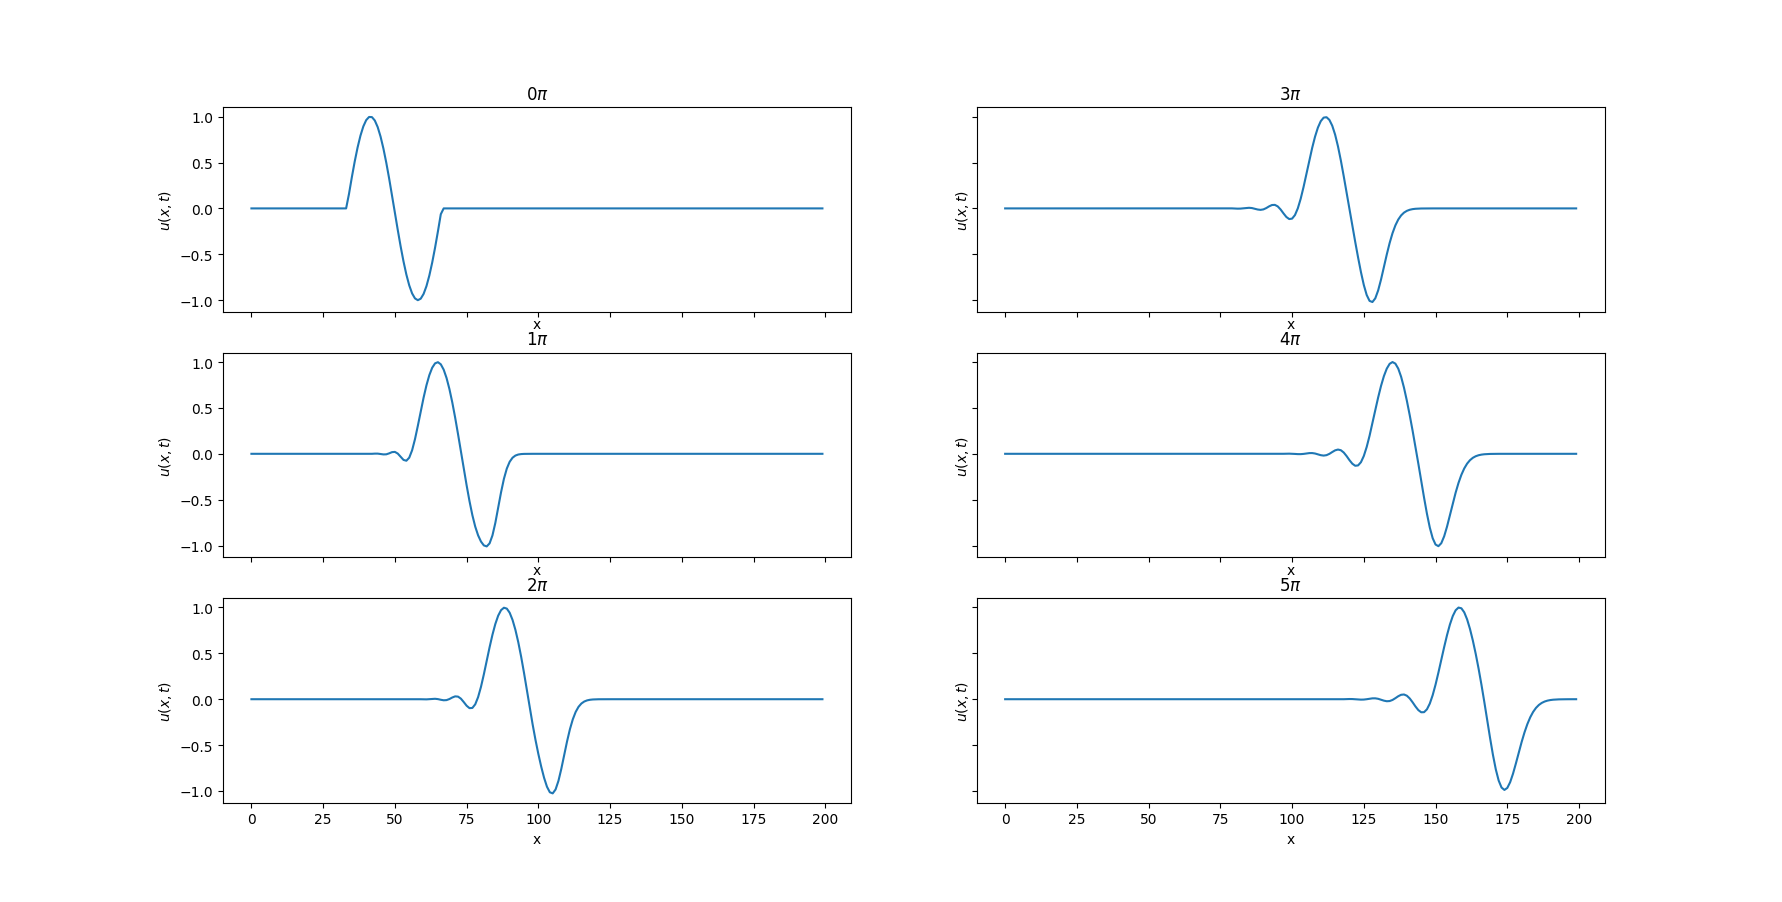

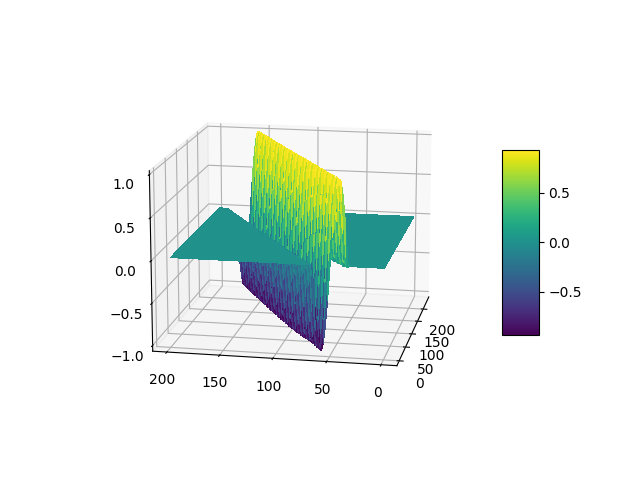

#### Comparing execution time for different number of threads

Executing the program with 2000 grid points yields the following results (on i5-3570k quad-core processor).

```sh
dx = 0.006003, dt = 0.006668, c = 0.500000, M=2357, N=2000 a=0.450158
Threads Used: 1 
Wall clock time:  = 0.3817595110 

dx = 0.006003, dt = 0.006668, c = 0.500000, M=2357, N=2000 a=0.450158
Threads Used: 2 
Wall clock time:  = 0.2068421270 

dx = 0.006003, dt = 0.006668, c = 0.500000, M=2357, N=2000 a=0.450158
Threads Used: 4 
Wall clock time:  = 0.1307446870 
```
Acceleration and plots are calculated below

Relative change between 1 and 2 threads is 45.82 %acceleration order 1.846
Relative change between 1 and 4 threads is 65.75 %acceleration order 2.92
Relative change between 2 and 4 threads is 36.79 %acceleration order 1.582


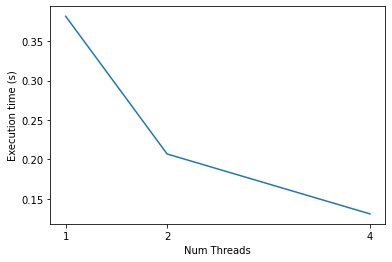

In [34]:
from matplotlib import pyplot as plt

exe_time = [0.3817595110, 0.2068421270, 0.130744687]
thrds = [1, 2, 4]

def rel_change(ini, fin):
    return abs((fin - ini) / ini)


print("Relative change between 1 and 2 threads is " 
      f"{100 * rel_change(exe_time[0], exe_time[1]):.4} %"
      f"acceleration order {exe_time[0]/exe_time[1]:.4}")
print("Relative change between 1 and 4 threads is "
      f"{100 * rel_change(exe_time[0], exe_time[2]):.4} %"
      f"acceleration order {exe_time[0]/exe_time[2]:.4}")
print("Relative change between 2 and 4 threads is "
      f"{100 * rel_change(exe_time[1], exe_time[2]):.4} %"
      f"acceleration order {exe_time[1]/exe_time[2]:.4}")


plt.plot([1, 2, 4], exe_time)
plt.xticks([ 1, 2, 4])
plt.xlabel("Num Threads")
plt.ylabel("Execution time (s)")
plt.show()

#### Verifying the results of parallelization

Another python script was created to verify the results of parallelization. The `c` script when run, will create a `txt` file containing the results, with a name according to the format `res%d_threads.txt` or `res_serial.txt` where the value of `%d` depends on the number of threads used. The python script, presented in the [Appendix](#compare_res.py), compares the numerical values of the results. 
The same result can be achieved by running `make verify`. The `Makefile` contains a `verify` recipe which first runs `run` and then compares the results of parallel execution to those of parallel execution (with a thread count of 4).

## Exercise 2

### Assignment

Convert the `matmul.c` program to use openMP. Present the solution of a small matrix multiplication and verify the results of execution match those of serial execution. Finally, run the program for a big number matrix multiplication and present the results with graphs and acceleration orders.

### Solution 

For the first part of the exercise, a matrix size of `9x9` was selected, and the code that implements the solution is presented below.

> Note, a condition which would force serial execution for small matrices (ROWS < 32|| COLUMNS < 32) has been commented out for this part of the exercise. Additionaly, prints for the initial assignment of values to matrices has been commented out.

`exe2/matmul_omp_tsouros.c`

```c
/****************************************
 ***
 *** SQUARE Matrix Multiplication (serial)
 ***
 ****************************************/

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define ROWS 9
#define COLUMNS 9

/* Prototype */
double ** array2D (int nRows, int nColumns);

int main(int argc, char **argv) {

  int i, j, k, paral_flag=0, num_t=1, small_mat=0;
  /* double sum; */
  double **a, **b, **c;

  /* Allocate Arrays */
  a = array2D(ROWS, COLUMNS);
  b = array2D(ROWS, COLUMNS);
  c = array2D(ROWS, COLUMNS);

  
  /* Argument Parsing for pallelization & number of threads to use */
  for (i = 1; i < argc; i++) {
    if (argv[i][0] == '-') {
      switch (argv[i][1]) {
      case 'p':
        paral_flag = 1;
        break;
      case 't':
        sscanf(argv[i + 1], "%d", &num_t);
        break;
      }
    }
  }

  /* Force serial execution for small matrices. Parallelization below
this limit results in increase in execution time. Also set small matrix flag
for writing to file. Commented out for comparing results of parallelization
for small matrices for the first part of exercise 2. */
  /* if (ROWS < 32 || COLUMNS < 32) { */
  /*   paral_flag = 0; */
  /*   small_mat = 1; */
  /* } */

  /* Initialize */

  for (i=0; i<ROWS; i++) {
    for (j=0; j<COLUMNS; j++) {
      a[i][j] = 3.0;
      b[i][j] = 2.0;
      c[i][j] = 0.0;
    }
  }

  /* if (ROWS < 10)  */
  /* { */
  /*   /\* TEST PRINT *\/   */
  /*   for (i=0; i<ROWS; i++) { */
  /*     for (j=0; j<COLUMNS; j++) { */
  /*       printf("%f ", a[i][j]); */
  /*     } */
  /*     printf("\n"); */
  /*   } */

  /*   for (i=0; i<ROWS; i++) { */
  /*     for (j=0; j<COLUMNS; j++) { */
  /*       printf("%f ", b[i][j]); */
  /*     } */
  /*     printf("\n"); */
  /*   } */

  /*   for (i=0; i<ROWS; i++) { */
  /*     for (j=0; j<COLUMNS; j++) { */
  /*       printf("%f ", c[i][j]); */
  /*     } */
  /*     printf("\n"); */
  /*   } */
  /*   printf("\n"); */
  /* } */

  /* Start timing */
  double start_time = omp_get_wtime(); 

  /* 
    Multiply Matrices 
    (SQUARE)
  */
#pragma omp parallel num_threads(num_t) shared(a,b,c) private(i,j,k)  if (paral_flag)
  {
#pragma omp for 
  for (i=0; i<ROWS; i++) {
    for (j=0; j<COLUMNS; j++) {
      for (k=0; k<COLUMNS; k++) {
        c[i][j] += a[i][k]*b[k][j];
      }
    }
  }
  }

  /* Stop Timing */
  double end_time = omp_get_wtime();

  /* Report Time */
  if (paral_flag){
    printf("[Matmul] Num Threads %d \nTime: %f seconds\n\n", num_t, (end_time - start_time));
  } else {
    printf("[Matmul] Serial Execution \nTime: %f seconds\n\n", (end_time - start_time));
  }

  /* PRINT RESULT */
  if (ROWS < 10)
  {
    for (i=0; i<ROWS; i++) {
      for (j=0; j<COLUMNS; j++) {
        printf("%f ", c[i][j]);
      }
      printf("\n");
    }
  }

  /* Write to file */
  FILE *fil;
  char filename[256];
  if (paral_flag) {
    snprintf(filename, sizeof(filename), "res%d_threads.txt", num_t);
  }
  else if (paral_flag==0 && small_mat) {
    snprintf(filename, sizeof(filename), "res%d_threads.txt", num_t);
  }
  else {
    snprintf(filename, sizeof(filename), "%s", "res_serial.txt");
  }
  fil = fopen(filename, "w");
  for (i = 0; i < ROWS; i++) {
    for (j = 0; j < COLUMNS; j++) {
      fprintf(fil, " %f", c[i][j]);
    }
  }


  /* Free Memory (Arrays) */
  free(a[0]); 
  free(a);
  free(b[0]); 
  free(b);
  free(c[0]); 
  free(c);
  return 0;
}


/* 
  Dynamically Allocates 2D Array  (Contiguous in Memory) 
*/
double ** array2D (int nRows, int nColumns) {
  
  int i;
  double ** array;

  /* Create rows (equal to gridPoints) */
  array = (double**)malloc(nRows*sizeof(double*));
  if (array == NULL) {
    printf("\n\n ERROR: Out of memory for output array! Exiting...\n\n");
    exit(-1);
  }

  /* Allocate enough memory for whole 2D array */
  array[0] = (double*)malloc(nRows*nColumns*sizeof(double));
  if (array[0] == NULL) {
    printf("\n\n ERROR: Out of memory for output array! Exiting...\n\n");
    exit(-1);
  }
  
  /* Point to individual rows */
  for (i=1;i<nRows;i++) {
    array[i] = array[0] + i*nColumns; 
  }

  return array;
}

```

#### Verification of results

The results of the execution are presented in the [Appendix](#Results-of-exercise-2-parallelization). Additionaly, a `Makefile` was created for this exercise too. Running `make verify` will compile the script, run it serially and using openMP for `{1, 2, 4}` threads and then run the [verify script](#compare_res.py), comparing the results of execution of the serial program with one using 4 threads for parallelization.

`Makefile` (exercise 2)

```sh
all: comp

OUT_FILE=tsouros2_matmul
build:
	@gcc -Wall -fopenmp -fsanitize=address matmul_omp_tsouros.c -o $(OUT_FILE) -lm

run: build
	@for number in 1 2 4; do \
		./$(OUT_FILE) -t $$number -N 2000 -p; \
		done
verify: build run
	@./$(OUT_FILE) -N 2000 -t 1
	python ../compare_res.py --files res4_threads.txt res_serial.txt

clean:
	@rm -f res*_threads.txt
	@rm -f res_serial.txt
	@rm -f $(OUT_FILE)


```

##### Discussion (small matrices execution)

The results are the same serial and parallel execution, thus it can be concluded that the parallelization works as intended. The execution time overhead added by the parallelization process is more than the acceleration it offers for small matrices, so it should not be used for small matrices.

> Note: It has been found that a matrix with a minimum size of `32x32` benefits from parallelization, therefore a condition that forces serial execution was added to the script for matrices smaller than that (commented out for the first part of the exercise).

### Solution (big matrix)

For this part of the exercise, a matrix with a size of `768x768` was selected.
Results are presented below:

```sh
» make verify

[Matmul] Num Threads 1 
Time: 6.452046 seconds

[Matmul] Num Threads 2 
Time: 3.167215 seconds

[Matmul] Num Threads 4 
Time: 1.566773 seconds

[Matmul] Serial Execution 
Time: 6.386022 seconds

python ../compare_res.py --files res4_threads.txt res_serial.txt
Results are the same for all test cases

```

##### Discusssion (big matrices execution)

Multiplication for big matrices benefits greatly from parallel execution. Results are presented below:


Relative change between 1 and 2 threads is 50.91 %acceleration order 2.037
Relative change between 1 and 4 threads is 75.72 %acceleration order 4.118
Relative change between 2 and 4 threads is 50.53 %acceleration order 2.021


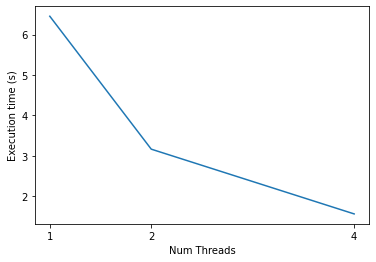

In [35]:
from matplotlib import pyplot as plt

exe_time = [6.452046, 3.167215, 1.566773]
thrds = [1, 2, 4]

def rel_change(ini, fin):
    return abs((fin - ini) / ini)



print("Relative change between 1 and 2 threads is " 
      f"{100 * rel_change(exe_time[0], exe_time[1]):.4} %"
      f"acceleration order {exe_time[0]/exe_time[1]:.4}")
print("Relative change between 1 and 4 threads is "
      f"{100 * rel_change(exe_time[0], exe_time[2]):.4} %"
      f"acceleration order {exe_time[0]/exe_time[2]:.4}")
print("Relative change between 2 and 4 threads is "
      f"{100 * rel_change(exe_time[1], exe_time[2]):.4} %"
      f"acceleration order {exe_time[1]/exe_time[2]:.4}")

plt.plot([1, 2, 4], exe_time)
plt.xticks([ 1, 2, 4])
plt.xlabel("Num Threads")
plt.ylabel("Execution time (s)")
plt.show()

## Exercise 3

### Description 

Convert a numerical analysis program to use openMP and execute it in way that proves the benefits of using openMP. Present your results accordinglt.

### Solution

For this exercise, a numerical differentation method was selected, as it is a good target for parallelization.
<h4> Solution (Numerical Differentation) </h4>

Numerical differentation can be achieved using finite-divided-difference formulas, using central differences for non-edge points, and forward/backward differences for edge points. The formulas are given below (aiming for $O(h^2)$ errors):

* Forward differences:

     \begin{equation} f'(x_i) = \frac{-f(x_{i+2}) + 4f(x_{i+1}) - 3f(x_i)}{2h} \end{equation}
     
* Backward differences:
    
     \begin{equation} f'(x_i) = \frac{3f(x_i) -4f(x_{i-1}) + f(x_{i-2})}{2h} \end{equation}
     
* Central differences:

    \begin{equation} f'(x_i) = \frac{f(x_{i+1}) - f(x_{i-1}) }{2h} \end{equation}
    
where $h$ is the step size of equidistant points.

Code that implements the above method is presented below

## Appendix


#### Plotting script

The python script used for plots is presented below:
`exe1/plot_res.py`
> Requirements `numpy` `matplotlib`

```python
import os

import numpy as np
    
from matplotlib import pyplot as plt
from matplotlib import animation, cm


class AnimateWave:
    def __init__(self, save_bool=False):
        self.inpt = np.fromfile(os.getcwd() + "/res1.txt", sep=" ")
        self.data = self.inpt.reshape(200, int(len(self.inpt) / 200))
        self.dt = 0.066978
        self.fig = plt.figure()
        self.ax = plt.axes(
            xlim=(0, self.data.shape[0]),
            ylim=(-1e11, 1e11),
        )
        self.x = np.arange(200)
        (self.p,) = self.ax.plot([], [], lw=2)
        
        self.sub_data = []
        self.pis = np.arange(5) * np.pi
        self.paused = False
        self.fig.canvas.mpl_connect("button_press_event", self.toggle_pause)
        self.save_bool = save_bool

    def __call__(self):
        self.anim = animation.FuncAnimation(
            self.fig,
            self.update,
            frames=self.data.shape[1],
            interval=60,
            blit=False,
            repeat=False,
            init_func=self._init_func
        )
        if self.save_bool:
            self.save_animation()

    def _init_func(self):
        return self.p
    
    def subplotting(self):
        sub_fig, sub_axes = plt.subplots(3, 2, sharex=True, sharey=True)
        for ax in sub_axes.flat:
            ax.set(xlabel="x", ylabel="$u(x,t)$")
        for idx, data in enumerate(self.sub_data):
            if idx < 3:
                sub_axes[idx, 0].plot(self.x, data)
                sub_axes[idx, 0].set_title(f"{idx}$\pi$")
            else:
                sub_axes[idx - 3, 1].plot(self.x, data)
                sub_axes[idx - 3, 1].set_title(f"{idx}$\pi$")

    def save_animation(self):
        self.anim.save(os.getcwd() + "/animationWave.gif")

    def check_pi(self, i):
        time_interval = self.dt * i
        pi_cond = np.isclose(time_interval, self.pis, atol=self.dt / 2)
        txt = f"{self.dt * i:.5}"
        is_pi = False
        if np.any(pi_cond):
            print(i)
            print("I m here")
            is_pi = True
            self.toggle_pause()
            idx = np.where(pi_cond == True)[0]
            if idx == 0:
                txt = "$0$"
            elif idx == 1:
                txt = "$\pi$"
            else:
                txt = f"{idx[0]}$\pi$"
        if i == self.data.shape[1] - 1:  # Last value should be closer to pi
            print("Or here")
            is_pi = True
            txt = "$5\pi$"
        return txt, is_pi

    def toggle_pause(self, *args, **kwargs):
        if self.paused:
            self.anim.event_source.start()
        else:
            self.anim.event_source.stop()
        self.paused = not self.paused

    def update(self, i):
        y = self.data[:, i]
        self.p.set_data(self.x, y)
        self.p.axes.set_ylim(-1.1, 1.1)
        self.p.axes.set_xlabel("$x$")
        self.p.axes.set_ylabel("$u(x, t)$")
        txt, is_pi = self.check_pi(i)
        if is_pi:
            self.sub_data.append(y)
        self.ax.set_title(f"Time {txt}")
        return self.p


def plot_3d_surf(data):
    fig, ax, = plt.subplots(subplot_kw={"projection": "3d"})
    x = np.arange(data.shape[0])
    y = np.arange(data.shape[1])
    X, Y = np.meshgrid(y, x)
    surf = ax.plot_surface(X, Y, data, cmap=cm.plasma, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


if __name__ == "__main__":
    a = AnimateWave()
    a()
    plt.show()
```


#### `compare_res.py`

A script that compares the (numerical) results of given `.txt` files.
> Requirements `numpy`

`compare_res.py`

```python
import glob
import argparse

import numpy as np


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--files", "-f", nargs="+", required=False)
    args = parser.parse_args()
    files = args.files
    if not args.files:
        files = glob.glob("res*_threads.txt")
    data = [np.fromfile(i, sep=" ") for i in files]
    comp = (np.diff(np.vstack(data).reshape(len(data), -1), axis=0)==0).all()
    if comp:
        print("Results are the same for all test cases")
    else:
        print("Results are different for different number of threads")

```

#### Results of exercise 2 parallelization

```sh
[Matmul] Num Threads 1 
Time: 0.000057 seconds

54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
[Matmul] Num Threads 2 
Time: 0.000414 seconds

54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
[Matmul] Num Threads 4 
Time: 0.005997 seconds

54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
[Matmul] Serial Execution 
Time: 0.000058 seconds

54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 54.000000 
python ../compare_res.py --files res4_threads.txt res_serial.txt
Results are the same for all test cases

```